**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной **(0 или 1, а НЕ вероятность)** для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv


In [33]:
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import r2_score as r2
from sklearn import base

# !pip install lightgbm
import lightgbm as lgbm

In [2]:
# График для оценки значимости признаков
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

    
# Oversampling   
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) # случайгое перемешивание данных


# Отчет для проверки качества модели
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    
    print('CONFUSION MATRIX TEST\n')
    print(pd.crosstab(y_test_true, y_test_pred))

    

# Графики для определения порога вероятности
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()



## Описание данных

### Целевая переменная

* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Основные признаки

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг

In [19]:
df_test = pd.read_csv('course_project_test.csv')
# df_test.describe()

In [20]:
df_train = pd.read_csv('course_project_train.csv')
# df_train.sample(5)

In [21]:
df_total = pd.concat([df_train, df_test], axis=0)

In [22]:
df_total.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.930000e+03,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,4561.000000,9983.000000,1.000000e+04,1.000000e+04,10000.000000,7930.000000,7500.000000
mean,1.366525e+06,0.031400,11.14430,18.319580,8.865079e+05,0.16800,34.564569,0.114595,1.194381e+07,2.914741e+05,18303.675600,1171.992182,0.281733
std,8.638276e+05,0.304341,4.89476,7.095357,1.389982e+07,0.51459,21.771990,0.349729,3.200878e+07,3.339979e+05,11831.647516,1639.812951,0.449874
min,1.065330e+05,0.000000,1.00000,3.900000,0.000000e+00,0.00000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.459892e+05,0.000000,8.00000,13.500000,2.788115e+05,0.00000,16.000000,0.000000,1.805485e+05,1.132258e+05,10059.750000,711.000000,0.000000
50%,1.168814e+06,0.000000,10.00000,17.000000,4.781810e+05,0.00000,32.000000,0.000000,3.117180e+05,2.090190e+05,16200.000000,731.000000,0.000000
75%,1.638693e+06,0.000000,14.00000,22.000000,7.943595e+05,0.00000,50.000000,0.000000,5.210700e+05,3.619500e+05,23888.250000,743.000000,1.000000
max,1.497561e+07,15.000000,48.00000,57.700000,1.304726e+09,15.00000,118.000000,5.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


## Предобработка данных

In [23]:
df_total.isnull().sum()

Home Ownership                     0
Annual Income                   2070
Years in current job             457
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    5439
Bankruptcies                      17
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
Credit Default                  2500
dtype: int64

В число задач предобоработки входит проверка категориальных признаков и заполнение пропущенных данных.

In [24]:
df_total['Years in current job'].value_counts()

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64

Категориальная переменая количества лет на текущем месте работы (**Years in current job**) может быть представлена порядковой шкалой.

In [25]:
work = {'< 1 year' : 0.5,
         '1 year' : 1.5,
         '2 years' : 2.5,
         '3 years' : 3.5,
         '4 years' : 4.5,
         '5 years' : 5.5,
         '6 years' : 6.5,
         '7 years' : 7.5,
         '8 years' : 8.5,
         '9 years' : 9.5,
         '10+ years' : 12.5}

df_total['Years in current job'] = df_total['Years in current job'].map(work)
df_total['Years in current job'].value_counts()

12.5    3142
2.5      917
3.5      848
0.5      770
5.5      685
1.5      657
4.5      621
6.5      563
7.5      536
8.5      446
9.5      358
Name: Years in current job, dtype: int64

In [8]:
df_total['Home Ownership'].value_counts()

Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64

Признак домовладения (**Home Ownership**) представлен четырями классами, один из которых нерепрезентативен ("Have Mortgage"). Скорее всего, этот класс существенным образом не отличается от "Home Mortgage". Напишем функцию, чтобы приравнять оба класса

In [9]:
def home_ownership(df):
    df['Home Ownership'] = df['Home Ownership'].replace('Have Mortgage','Home Mortgage')

home_ownership(df_total)
df_total['Home Ownership'].value_counts()

Home Mortgage    4881
Rent             4224
Own Home          895
Name: Home Ownership, dtype: int64

Поменяем тип данных для признаков **Home Ownership**, **Purpose** и **Term** на категориальный

In [58]:
# df_total.dtypes
for c in ['Home Ownership', 'Term', 'Purpose']:
    df_total[c] = df_total[c].astype('category')

Home Ownership                  category
Annual Income                    float64
Years in current job             float64
Tax Liens                        float64
Number of Open Accounts          float64
Years of Credit History          float64
Maximum Open Credit              float64
Number of Credit Problems        float64
Months since last delinquent     float64
Bankruptcies                     float64
Purpose                         category
Term                            category
Current Loan Amount              float64
Current Credit Balance           float64
Monthly Debt                     float64
Credit Score                     float64
Credit Default                   float64
dtype: object

In [54]:
# def purpose(df):
#     df.loc[df['Purpose'].isin(['debt consolidation']), 'Class'] = 'consolidation'
#     df.loc[df['Purpose'].isin(['business loan', 'small business']), 'Class'] = 'business'
#     df.loc[df['Class'].isnull(), 'Class'] = 'consumers and others'


Для заполнения данных по показателю **"Months since last delinquent"** использовалась доступная информация по кредитной истории рассматриваемых заемщиков:
- Если у заемщика не было проблем с кредитами, то значение "Months since last delinquent" приравнивалось к длительности кредитной истории
- Если у заемщика были проблемы с кредитами, то значение "Months since last delinquent" приравнивалось к медианному значению этого признака по группе заемщиков с аналогичным количеством проблем по выплате кредитов

Кроме того, чтобы не потерять важные свойства признака, создадим булевый показатель **"Delinquent"**. Единичка будет выделять заемщиков, по которым точно была просрочка. Ноль - всех остальных.

In [59]:
def delinquent(df):
    # Добавление булевого показателя
    if 'Delinquent' not in df:
        df["Delinquent"] = np.where((df['Months since last delinquent'].isnull()) 
                                & (df['Number of Credit Problems'] == 0), 
                                0, 1)
    df["Delinquent"] = df["Delinquent"].astype('bool')
    
    # Вычислений медиан для каждой группы заемщиков
    groupby = df.groupby('Number of Credit Problems')
    medians = groupby['Months since last delinquent'].median()
    
    # Заполнение пропусков
    if df["Months since last delinquent"].isnull().sum() != 0:
        df["Months since last delinquent"] = np.where((df['Number of Credit Problems'] == 0) &
                                                            df['Months since last delinquent'].isnull(), 
                                                            df['Years of Credit History']*12,
                                                            medians[df['Number of Credit Problems']])


In [60]:
delinquent(df_total)
df_total.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.930000e+03,9543.000000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,10000.000000,9983.000000,1.000000e+04,1.000000e+04,10000.000000,7930.000000,7500.000000
mean,1.366525e+06,7.056429,0.031400,11.14430,18.319580,8.865079e+05,0.16800,114.801860,0.114595,1.194381e+07,2.914741e+05,18303.675600,1171.992182,0.281733
std,8.638276e+05,4.406952,0.304341,4.89476,7.095357,1.389982e+07,0.51459,103.929474,0.349729,3.200878e+07,3.339979e+05,11831.647516,1639.812951,0.449874
min,1.065330e+05,0.500000,0.000000,1.00000,3.900000,0.000000e+00,0.00000,30.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.459892e+05,3.500000,0.000000,8.00000,13.500000,2.788115e+05,0.00000,30.000000,0.000000,1.805485e+05,1.132258e+05,10059.750000,711.000000,0.000000
50%,1.168814e+06,6.500000,0.000000,10.00000,17.000000,4.781810e+05,0.00000,41.500000,0.000000,3.117180e+05,2.090190e+05,16200.000000,731.000000,0.000000
75%,1.638693e+06,12.500000,0.000000,14.00000,22.000000,7.943595e+05,0.00000,187.200000,0.000000,5.210700e+05,3.619500e+05,23888.250000,743.000000,1.000000
max,1.497561e+07,12.500000,15.000000,48.00000,57.700000,1.304726e+09,15.00000,640.800000,5.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Пропущенные данные по количеству банкротств (**"Bankruptcies"**) заполним медианным значением по группе заемщиков с таким же количеством проблем с кредитами (**"Number of Credit Problems"**)

In [61]:
def bankruptcies(df):
    # Вычислений медиан для каждой группы заемщиков
    groupby = df.groupby('Number of Credit Problems')
    medians = groupby['Bankruptcies'].median()
    
    # Заполнение пропусков
    df['Bankruptcies'] = np.where(df['Bankruptcies'].isnull(), medians[df['Number of Credit Problems']], df['Bankruptcies'])

In [62]:
bankruptcies(df_total)
df_total['Bankruptcies'].isnull().sum()

0

В столбце с показателем **"Сurrent loan amount"** можно заметить сильный выброс (99999999) у большого количества наблюдений. Скорее всего, это связано с ошибкой заполнения данных. Попробуем решить ее с помощью модели lightgbm

In [77]:
target = 'Current Loan Amount'

features = df_total.columns.tolist()
features.remove('Current Loan Amount')

categorical = ['Home Ownership', 'Term', 'Purpose', 'Years in current job', 'Delinquent']

In [81]:
y = df_total.loc[(df_total[target] != 99999999), target]
x = df_total.loc[(df_total[target] != 99999999), features]

# x.isnull().sum()

Home Ownership                     0
Annual Income                   2070
Years in current job             410
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Purpose                            0
Term                               0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    2070
Credit Default                  2203
Delinquent                         0
dtype: int64

In [82]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, shuffle=True, test_size=0.25, random_state=211)

In [87]:
loan_lgbm = lgbm.LGBMRegressor(random_state=21, catgorical_features=categorical)

In [88]:
%%time

loan_lgbm.fit(x_train,y_train)

Wall time: 374 ms


LGBMRegressor(boosting_type='gbdt',
              catgorical_features=['Home Ownership', 'Term', 'Purpose',
                                   'Years in current job', 'Delinquent'],
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              learning_rate=0.1, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31, objective=None, random_state=21,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [89]:
r2(y_valid, loan_lgbm.predict(x_valid))

0.5010016706157978

In [90]:
param_grid = {'num_leaves': [15, 32, 70, 128, 150], 
              'max_depth': [5, 7, 10, 12, 15]}

In [91]:
grid_searcher = GridSearchCV(estimator=loan_lgbm, param_grid=param_grid, 
                             cv=5, verbose=1, n_jobs=4)

In [92]:
grid_searcher.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   25.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt',
                                     catgorical_features=['Home Ownership',
                                                          'Term', 'Purpose',
                                                          'Years in current '
                                                          'job',
                                                          'Delinquent'],
                                     class_weight=None, colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=21,
                                     reg_alpha=0.0, reg_lambda=0.0, sile

In [93]:
grid_searcher.best_params_, grid_searcher.best_score_

({'max_depth': 5, 'num_leaves': 15}, 0.4860651090490847)

In [95]:
r2(y_valid, grid_searcher.predict(x_valid))

0.5117195985251826

In [99]:
loan_lgbm2 = lgbm.LGBMRegressor(random_state=17, max_depth=5, 
                          num_leaves=15, n_jobs=1)

param_grid2 = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
               'n_estimators': [500, 1000, 1200, 1500]}

grid_searcher2 = GridSearchCV(estimator=loan_lgbm2, param_grid=param_grid2,
                               cv=5, verbose=1, n_jobs=4)

grid_searcher2.fit(x_train, y_train)
print(grid_searcher2.best_params_, grid_searcher2.best_score_)
print(r2(y_valid, grid_searcher2.predict(x_valid)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   56.4s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  1.7min finished


{'learning_rate': 0.01, 'n_estimators': 500} 0.4893241632023722
0.5122824206738996


Произведем прогноз на основе полученной модели

In [101]:
loan_lgbm = lgbm.LGBMRegressor(random_state=17, max_depth=5, 
                          num_leaves=15, n_jobs=1, learning_rate = 0.01, n_estimators = 500)

loan_lgbm.fit(x, y)

x_loan = df_total.loc[(df_total[target] == 99999999), features]

df_total.loc[(df_total[target] == 99999999), target] = loan_lgbm.predict(x_loan)
df_total.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.930000e+03,9543.000000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,7930.000000,7500.000000
mean,1.366525e+06,7.056429,0.031400,11.14430,18.319580,8.865079e+05,0.16800,114.801860,0.114400,308663.811336,2.914741e+05,18303.675600,1171.992182,0.281733
std,8.638276e+05,4.406952,0.304341,4.89476,7.095357,1.389982e+07,0.51459,103.929474,0.349464,176267.263441,3.339979e+05,11831.647516,1639.812951,0.449874
min,1.065330e+05,0.500000,0.000000,1.00000,3.900000,0.000000e+00,0.00000,30.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,8.459892e+05,3.500000,0.000000,8.00000,13.500000,2.788115e+05,0.00000,30.000000,0.000000,175406.000000,1.132258e+05,10059.750000,711.000000,0.000000
50%,1.168814e+06,6.500000,0.000000,10.00000,17.000000,4.781810e+05,0.00000,41.500000,0.000000,268356.000000,2.090190e+05,16200.000000,731.000000,0.000000
75%,1.638693e+06,12.500000,0.000000,14.00000,22.000000,7.943595e+05,0.00000,187.200000,0.000000,420387.000000,3.619500e+05,23888.250000,743.000000,1.000000
max,1.497561e+07,12.500000,15.000000,48.00000,57.700000,1.304726e+09,15.00000,640.800000,5.000000,789096.000000,6.506797e+06,136679.000000,7510.000000,1.000000


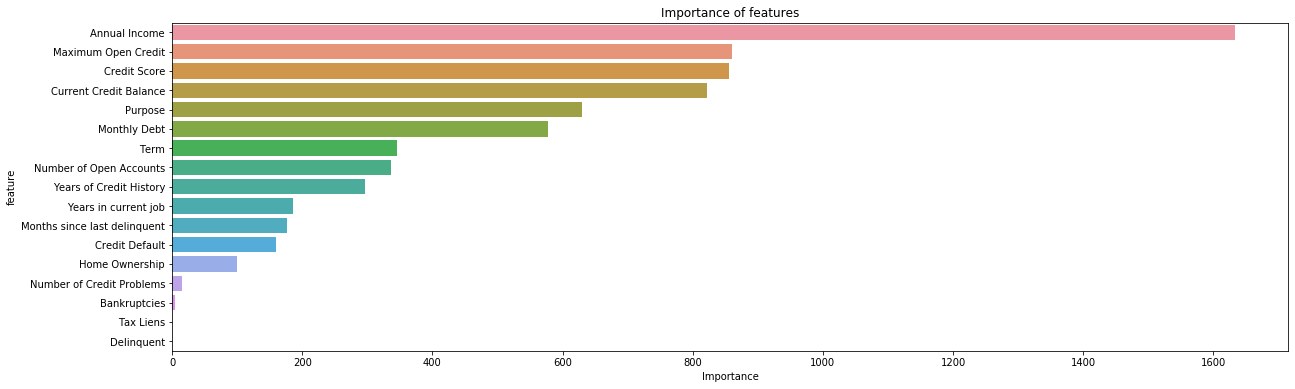

In [103]:
show_feature_importances(x.columns, loan_lgbm.feature_importances_)

Заполненим пропуски в столбце **"Annual income"** с помощью lightgbm

In [105]:
target = 'Annual Income'

features = df_total.columns.tolist()
features.remove('Annual Income')

In [106]:
y = df_total.loc[df_total[target].notnull(), target]
x = df_total.loc[df_total[target].notnull(), features]

# x.isnull().sum()

In [107]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, shuffle=True, test_size=0.25, random_state=211)

In [108]:
income_lgbm = lgbm.LGBMRegressor(random_state=21, catgorical_features=categorical)

In [109]:
%%time

income_lgbm.fit(x_train,y_train)

Wall time: 484 ms


LGBMRegressor(boosting_type='gbdt',
              catgorical_features=['Home Ownership', 'Term', 'Purpose',
                                   'Years in current job', 'Delinquent'],
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              learning_rate=0.1, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31, objective=None, random_state=21,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [110]:
r2(y_valid, income_lgbm.predict(x_valid))

0.4537770394573496

In [111]:
param_grid = {'num_leaves': [15, 32, 70, 128, 150], 
              'max_depth': [5, 7, 10, 12, 15]}

In [112]:
grid_searcher = GridSearchCV(estimator=income_lgbm, param_grid=param_grid, 
                             cv=5, verbose=1, n_jobs=4)

In [113]:
grid_searcher.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   19.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt',
                                     catgorical_features=['Home Ownership',
                                                          'Term', 'Purpose',
                                                          'Years in current '
                                                          'job',
                                                          'Delinquent'],
                                     class_weight=None, colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=21,
                                     reg_alpha=0.0, reg_lambda=0.0, sile

In [114]:
grid_searcher.best_params_, grid_searcher.best_score_

({'max_depth': 5, 'num_leaves': 15}, 0.41558080140553244)

In [115]:
r2(y_valid, grid_searcher.predict(x_valid))

0.46008005069221747

In [116]:
income_lgbm2 = lgbm.LGBMRegressor(random_state=17, max_depth=5, 
                          num_leaves=15, n_jobs=1)

param_grid2 = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
               'n_estimators': [500, 1000, 1200, 1500]}

grid_searcher2 = GridSearchCV(estimator=income_lgbm2, param_grid=param_grid2,
                               cv=5, verbose=1, n_jobs=4)

grid_searcher2.fit(x_train, y_train)
print(grid_searcher2.best_params_, grid_searcher2.best_score_)
print(r2(y_valid, grid_searcher2.predict(x_valid)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  1.3min finished


{'learning_rate': 0.01, 'n_estimators': 1000} 0.42022631348368555
0.4727467061503031


Произведем прогноз на основе полученной модели

In [117]:
income_lgbm = lgbm.LGBMRegressor(random_state=17, max_depth=5, 
                          num_leaves=15, n_jobs=1, learning_rate = 0.01, n_estimators = 1000)

income_lgbm.fit(x, y)

x_income = df_total.loc[df_total[target].isnull(), features]

df_total.loc[df_total[target].isnull(), target] = income_lgbm.predict(x_income)
df_total.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,1.000000e+04,9543.000000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,7930.000000,7500.000000
mean,1.343690e+06,7.056429,0.031400,11.14430,18.319580,8.865079e+05,0.16800,114.801860,0.114400,308663.811336,2.914741e+05,18303.675600,1171.992182,0.281733
std,8.146035e+05,4.406952,0.304341,4.89476,7.095357,1.389982e+07,0.51459,103.929474,0.349464,176267.263441,3.339979e+05,11831.647516,1639.812951,0.449874
min,1.065330e+05,0.500000,0.000000,1.00000,3.900000,0.000000e+00,0.00000,30.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000
25%,8.551417e+05,3.500000,0.000000,8.00000,13.500000,2.788115e+05,0.00000,30.000000,0.000000,175406.000000,1.132258e+05,10059.750000,711.000000,0.000000
50%,1.162325e+06,6.500000,0.000000,10.00000,17.000000,4.781810e+05,0.00000,41.500000,0.000000,268356.000000,2.090190e+05,16200.000000,731.000000,0.000000
75%,1.595461e+06,12.500000,0.000000,14.00000,22.000000,7.943595e+05,0.00000,187.200000,0.000000,420387.000000,3.619500e+05,23888.250000,743.000000,1.000000
max,1.497561e+07,12.500000,15.000000,48.00000,57.700000,1.304726e+09,15.00000,640.800000,5.000000,789096.000000,6.506797e+06,136679.000000,7510.000000,1.000000


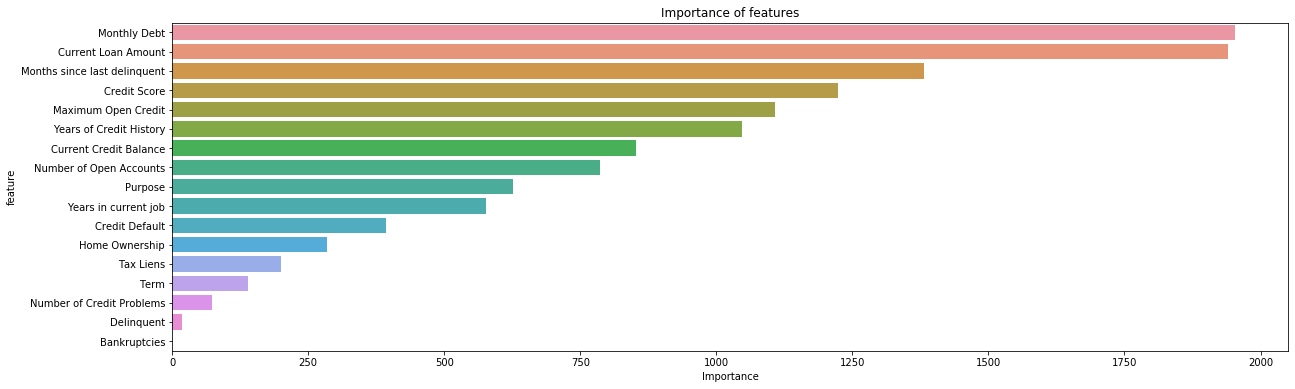

In [118]:
show_feature_importances(x.columns, income_lgbm.feature_importances_)

## Новые признаки

* **DTI** $= \frac{Monthly Debt*12}{Annual Income}$
    
    Отношение величины ежемесячной задолженности к доходу
    
    
* **Payback period** $= \frac{Current Loan Amount + Current Credit Balance}{Annual Income} $
    
    Количество лет на погашение текущего долга за счет годового дохода


* **Bankruptcies-per-year** $= \frac{Bankruptcies}{Years Of Credit History}$

    Количество банкротств с учетом длительности кредитной истории


* **Problems-per-year** $= \frac{Number Of Credit Problems}{Years Of Credit History}$

    Количество проблем (просрочек?) с учетом длительности кредитной истории


In [119]:
def new_features(df):
    df['DTI'] = df['Monthly Debt']*12/df['Annual Income']
    df['Payback period'] = (df['Current Loan Amount']+df['Current Credit Balance'])/df['Annual Income']
    df['Bankruptcies-per-year'] = df['Bankruptcies']/df['Years of Credit History']
    df['Problems-per-year'] = df['Number of Credit Problems']/df['Years of Credit History']
    

In [120]:
new_features(df_total)
df_total.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,DTI,Payback period,Bankruptcies-per-year,Problems-per-year
count,1.000000e+04,9543.000000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,7930.000000,7500.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.343690e+06,7.056429,0.031400,11.14430,18.319580,8.865079e+05,0.16800,114.801860,0.114400,308663.811336,2.914741e+05,18303.675600,1171.992182,0.281733,0.171071,0.474217,0.006349,0.009505
std,8.146035e+05,4.406952,0.304341,4.89476,7.095357,1.389982e+07,0.51459,103.929474,0.349464,176267.263441,3.339979e+05,11831.647516,1639.812951,0.449874,0.076354,0.243312,0.020418,0.030542
min,1.065330e+05,0.500000,0.000000,1.00000,3.900000,0.000000e+00,0.00000,30.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.010546,0.000000,0.000000
25%,8.551417e+05,3.500000,0.000000,8.00000,13.500000,2.788115e+05,0.00000,30.000000,0.000000,175406.000000,1.132258e+05,10059.750000,711.000000,0.000000,0.115003,0.301925,0.000000,0.000000
50%,1.162325e+06,6.500000,0.000000,10.00000,17.000000,4.781810e+05,0.00000,41.500000,0.000000,268356.000000,2.090190e+05,16200.000000,731.000000,0.000000,0.171997,0.440249,0.000000,0.000000
75%,1.595461e+06,12.500000,0.000000,14.00000,22.000000,7.943595e+05,0.00000,187.200000,0.000000,420387.000000,3.619500e+05,23888.250000,743.000000,1.000000,0.223863,0.606059,0.000000,0.000000
max,1.497561e+07,12.500000,15.000000,48.00000,57.700000,1.304726e+09,15.00000,640.800000,5.000000,789096.000000,6.506797e+06,136679.000000,7510.000000,1.000000,0.399009,3.165647,0.301205,0.746269


Попробуем заполнить пропущенные данные **"Credit Score"**, предварительно исправив выбросы в выборке

In [121]:
df_total.loc[df_total['Credit Score'] > 1000, 'Credit Score'] = df_total.loc[df_total['Credit Score'] > 1000, 'Credit Score']/10
df_total.describe()


,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,DTI,Payback period,Bankruptcies-per-year,Problems-per-year
count,1.000000e+04,9543.000000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,7930.000000,7500.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.343690e+06,7.056429,0.031400,11.14430,18.319580,8.865079e+05,0.16800,114.801860,0.114400,308663.811336,2.914741e+05,18303.675600,719.950441,0.281733,0.171071,0.474217,0.006349,0.009505
std,8.146035e+05,4.406952,0.304341,4.89476,7.095357,1.389982e+07,0.51459,103.929474,0.349464,176267.263441,3.339979e+05,11831.647516,27.898302,0.449874,0.076354,0.243312,0.020418,0.030542
min,1.065330e+05,0.500000,0.000000,1.00000,3.900000,0.000000e+00,0.00000,30.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.010546,0.000000,0.000000
25%,8.551417e+05,3.500000,0.000000,8.00000,13.500000,2.788115e+05,0.00000,30.000000,0.000000,175406.000000,1.132258e+05,10059.750000,708.000000,0.000000,0.115003,0.301925,0.000000,0.000000
50%,1.162325e+06,6.500000,0.000000,10.00000,17.000000,4.781810e+05,0.00000,41.500000,0.000000,268356.000000,2.090190e+05,16200.000000,728.000000,0.000000,0.171997,0.440249,0.000000,0.000000
75%,1.595461e+06,12.500000,0.000000,14.00000,22.000000,7.943595e+05,0.00000,187.200000,0.000000,420387.000000,3.619500e+05,23888.250000,740.000000,1.000000,0.223863,0.606059,0.000000,0.000000
max,1.497561e+07,12.500000,15.000000,48.00000,57.700000,1.304726e+09,15.00000,640.800000,5.000000,789096.000000,6.506797e+06,136679.000000,751.000000,1.000000,0.399009,3.165647,0.301205,0.746269


In [122]:
target = 'Credit Score'

features = df_total.columns.tolist()
features.remove('Credit Score')

In [123]:
y = df_total.loc[df_total[target].notnull(), target]
x = df_total.loc[df_total[target].notnull(), features]

# x.isnull().sum()

In [124]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, shuffle=True, test_size=0.25, random_state=211)

In [125]:
score_lgbm = lgbm.LGBMRegressor(random_state=21, catgorical_features=categorical)

In [126]:
%%time

score_lgbm.fit(x_train,y_train)

Wall time: 658 ms


LGBMRegressor(boosting_type='gbdt',
              catgorical_features=['Home Ownership', 'Term', 'Purpose',
                                   'Years in current job', 'Delinquent'],
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              learning_rate=0.1, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31, objective=None, random_state=21,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [127]:
r2(y_valid, score_lgbm.predict(x_valid))

0.3442702001454392

In [128]:
param_grid = {'num_leaves': [15, 32, 70, 128, 150], 
              'max_depth': [5, 7, 10, 12, 15]}

In [129]:
grid_searcher = GridSearchCV(estimator=score_lgbm, param_grid=param_grid, 
                             cv=5, verbose=1, n_jobs=4)

In [130]:
grid_searcher.fit(x_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   25.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt',
                                     catgorical_features=['Home Ownership',
                                                          'Term', 'Purpose',
                                                          'Years in current '
                                                          'job',
                                                          'Delinquent'],
                                     class_weight=None, colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=21,
                                     reg_alpha=0.0, reg_lambda=0.0, sile

In [114]:
grid_searcher.best_params_, grid_searcher.best_score_

({'max_depth': 5, 'num_leaves': 15}, 0.41558080140553244)

In [115]:
r2(y_valid, grid_searcher.predict(x_valid))

0.46008005069221747

In [131]:
score_lgbm2 = lgbm.LGBMRegressor(random_state=17, max_depth=5, 
                          num_leaves=15, n_jobs=1)

param_grid2 = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
               'n_estimators': [500, 1000, 1200, 1500]}

grid_searcher2 = GridSearchCV(estimator=score_lgbm2, param_grid=param_grid2,
                               cv=5, verbose=1, n_jobs=4)

grid_searcher2.fit(x_train, y_train)
print(grid_searcher2.best_params_, grid_searcher2.best_score_)
print(r2(y_valid, grid_searcher2.predict(x_valid)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   58.9s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  1.8min finished


{'learning_rate': 0.01, 'n_estimators': 1000} 0.3487481940477945
0.36617381720985775


Произведем прогноз на основе полученной модели

In [132]:
score_lgbm2.fit(x, y)

x_score = df_total.loc[df_total[target].isnull(), features]

df_total.loc[df_total[target].isnull(), target] = score_lgbm2.predict(x_score)
df_total.describe()


,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,DTI,Payback period,Bankruptcies-per-year,Problems-per-year
count,1.000000e+04,9543.000000,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,7500.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.343690e+06,7.056429,0.031400,11.14430,18.319580,8.865079e+05,0.16800,114.801860,0.114400,308663.811336,2.914741e+05,18303.675600,720.263579,0.281733,0.171071,0.474217,0.006349,0.009505
std,8.146035e+05,4.406952,0.304341,4.89476,7.095357,1.389982e+07,0.51459,103.929474,0.349464,176267.263441,3.339979e+05,11831.647516,25.908401,0.449874,0.076354,0.243312,0.020418,0.030542
min,1.065330e+05,0.500000,0.000000,1.00000,3.900000,0.000000e+00,0.00000,30.000000,0.000000,11242.000000,0.000000e+00,0.000000,585.000000,0.000000,0.000000,0.010546,0.000000,0.000000
25%,8.551417e+05,3.500000,0.000000,8.00000,13.500000,2.788115e+05,0.00000,30.000000,0.000000,175406.000000,1.132258e+05,10059.750000,709.000000,0.000000,0.115003,0.301925,0.000000,0.000000
50%,1.162325e+06,6.500000,0.000000,10.00000,17.000000,4.781810e+05,0.00000,41.500000,0.000000,268356.000000,2.090190e+05,16200.000000,727.284023,0.000000,0.171997,0.440249,0.000000,0.000000
75%,1.595461e+06,12.500000,0.000000,14.00000,22.000000,7.943595e+05,0.00000,187.200000,0.000000,420387.000000,3.619500e+05,23888.250000,739.000000,1.000000,0.223863,0.606059,0.000000,0.000000
max,1.497561e+07,12.500000,15.000000,48.00000,57.700000,1.304726e+09,15.00000,640.800000,5.000000,789096.000000,6.506797e+06,136679.000000,753.851459,1.000000,0.399009,3.165647,0.301205,0.746269


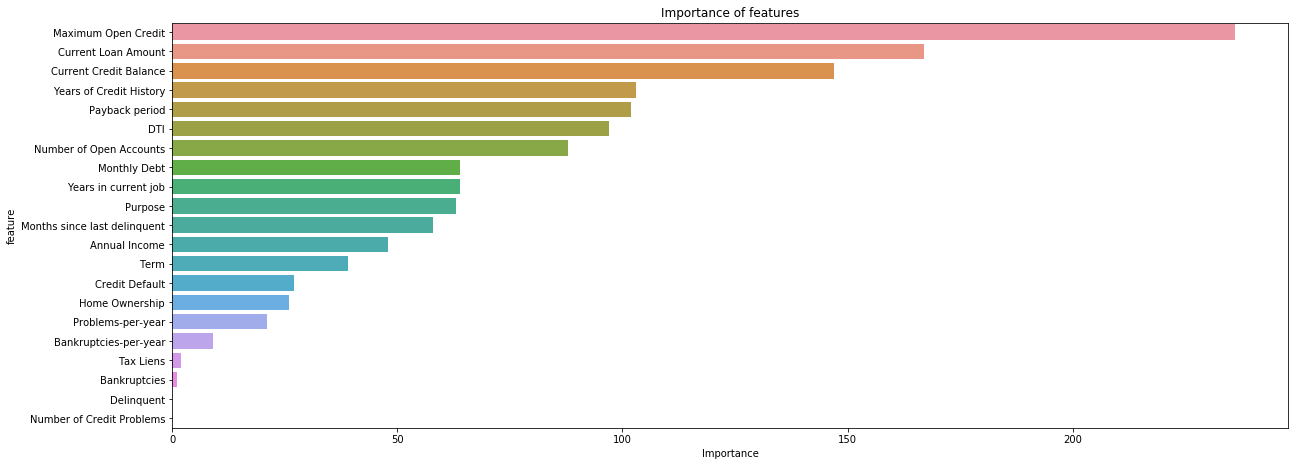

In [133]:
show_feature_importances(x.columns, score_lgbm2.feature_importances_)

Построим корреляционную матрицу, чтобы оценить взаимосвязь признаков

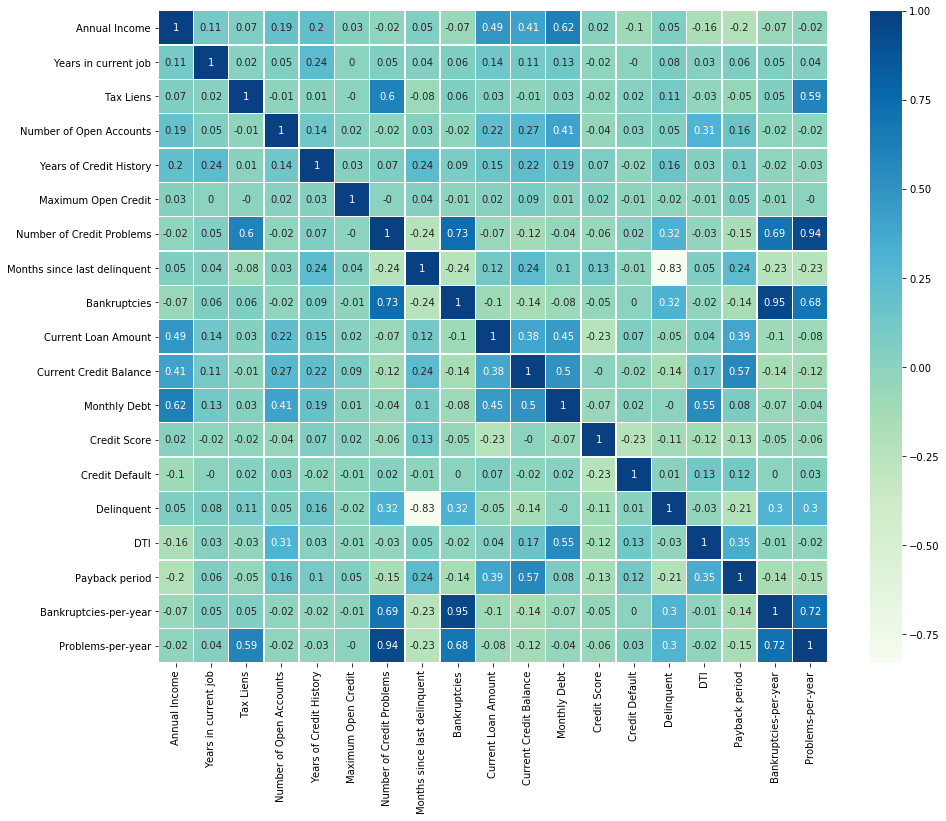

In [134]:
df_train = df_total.loc[df_total['Credit Default'].notnull()]
df_test = df_total.loc[df_total['Credit Default'].isnull()]

plt.figure(figsize=(15, 12))
sns.heatmap(df_train.corr().round(2), annot=True, linewidths=.5, cmap='GnBu')

## Балансировка

In [135]:
df_train['Credit Default'].value_counts()

0.0    5387
1.0    2113
Name: Credit Default, dtype: int64

In [136]:
TARGET = 'Credit Default'

FEATURES = df_train.columns.to_list() 
FEATURES.remove('Credit Default')

**Разбиение выборки**

In [137]:
X = df_train[FEATURES]
y = df_train[TARGET]

x_train, x_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

**Oversampling**

In [138]:
df_for_balancing = pd.concat([x_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET)
    
df_balanced[TARGET].value_counts()

0.0    4047
1.0    3156
Name: Credit Default, dtype: int64

In [139]:
x_train = df_balanced.drop(columns=TARGET)
y_train = df_balanced[TARGET]


## Модель

In [140]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(x_train, y_train)

y_train_pred = model_lgbm.predict(x_train)
y_valid_pred = model_lgbm.predict(x_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      4047
         1.0       0.91      0.88      0.89      3156

    accuracy                           0.91      7203
   macro avg       0.91      0.90      0.91      7203
weighted avg       0.91      0.91      0.91      7203

TEST

              precision    recall  f1-score   support

         0.0       0.78      0.79      0.79      1340
         1.0       0.46      0.44      0.45       535

    accuracy                           0.69      1875
   macro avg       0.62      0.62      0.62      1875
weighted avg       0.69      0.69      0.69      1875

CONFUSION MATRIX TEST

col_0            0.0  1.0
Credit Default           
0.0             1065  275
1.0              297  238


**Подбор гиперпараметров**

In [142]:
model_lgbm = lgbm.LGBMClassifier(random_state=21, catgorical_features=categorical)

In [143]:
params = {'n_estimators':[100, 200, 500, 1000, 1500],
          'num_leaves': [20, 50, 100, 128, 150],
          'min_data_in_leaf': [20, 50, 100],
          'max_depth': [5, 7, 10, 15],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}

In [144]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [145]:
%%time

rs = RandomizedSearchCV(model_lgbm, param_distributions=params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(x_train, y_train)

Wall time: 8.59 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            catgorical_features=['Home '
                                                                 'Ownership',
                                                                 'Term',
                                                                 'Purpose',
                                                                 'Years in '
                                                                 'current job',
                                                                 'Delinquent'],
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
              

In [146]:
rs.best_params_

{'num_leaves': 150,
 'n_estimators': 200,
 'min_data_in_leaf': 20,
 'max_depth': 10,
 'learning_rate': 0.05}

In [147]:
rs.best_score_

0.7606533925304092

In [148]:
%%time

final_model = lgbm.LGBMClassifier(n_estimators=200, num_leaves=150, max_depth=10, learning_rate=0.05,
                                      min_data_in_leaf=20, random_state=21, catgorical_features=categorical)
final_model.fit(x_train, y_train)

y_train_pred = final_model.predict(x_train)
y_valid_pred = final_model.predict(x_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4047
         1.0       0.99      0.99      0.99      3156

    accuracy                           0.99      7203
   macro avg       0.99      0.99      0.99      7203
weighted avg       0.99      0.99      0.99      7203

TEST

              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81      1340
         1.0       0.49      0.40      0.44       535

    accuracy                           0.71      1875
   macro avg       0.64      0.62      0.62      1875
weighted avg       0.70      0.71      0.70      1875

CONFUSION MATRIX TEST

col_0            0.0  1.0
Credit Default           
0.0             1120  220
1.0              321  214
Wall time: 2.1 s


In [160]:
%%time

final_model = lgbm.LGBMClassifier(n_estimators=200, num_leaves=150, max_depth=10, learning_rate=0.05, lambda_l2 = 300,
                                      min_data_in_leaf=20, random_state=21, catgorical_features=categorical)
final_model.fit(x_train, y_train)


y_train_pred = final_model.predict(x_train)
y_valid_pred = final_model.predict(x_valid)
y_valid_pred_probs = final_model.predict_proba(x_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78      4047
         1.0       0.73      0.66      0.69      3156

    accuracy                           0.74      7203
   macro avg       0.74      0.74      0.74      7203
weighted avg       0.74      0.74      0.74      7203

TEST

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78      1340
         1.0       0.46      0.51      0.49       535

    accuracy                           0.69      1875
   macro avg       0.63      0.64      0.63      1875
weighted avg       0.70      0.69      0.69      1875

CONFUSION MATRIX TEST

col_0            0.0  1.0
Credit Default           
0.0             1020  320
1.0              261  274
Wall time: 1.98 s


C:\Users\walde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


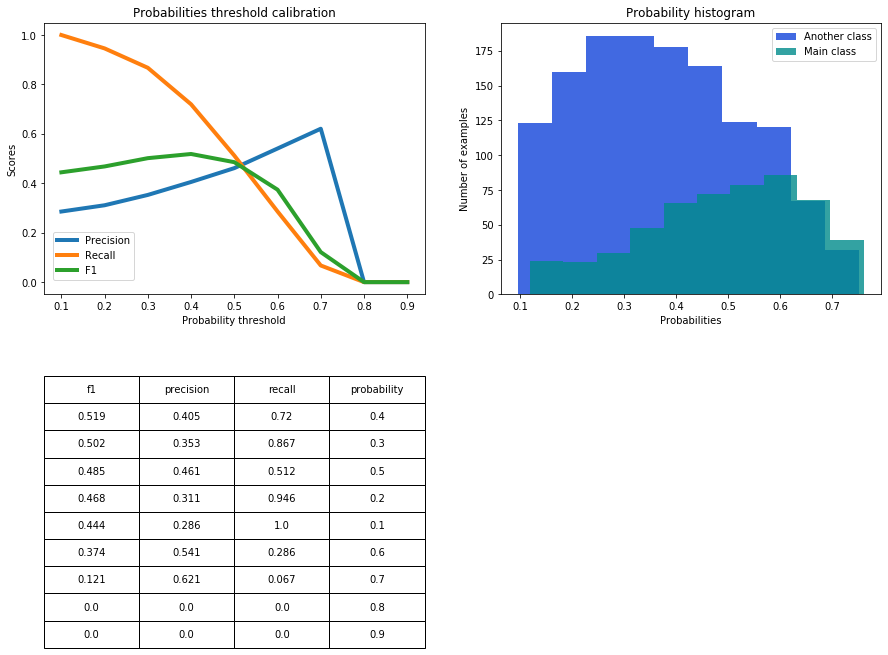

In [161]:
show_proba_calibration_plots(y_valid_pred_probs[:, 1], y_valid)

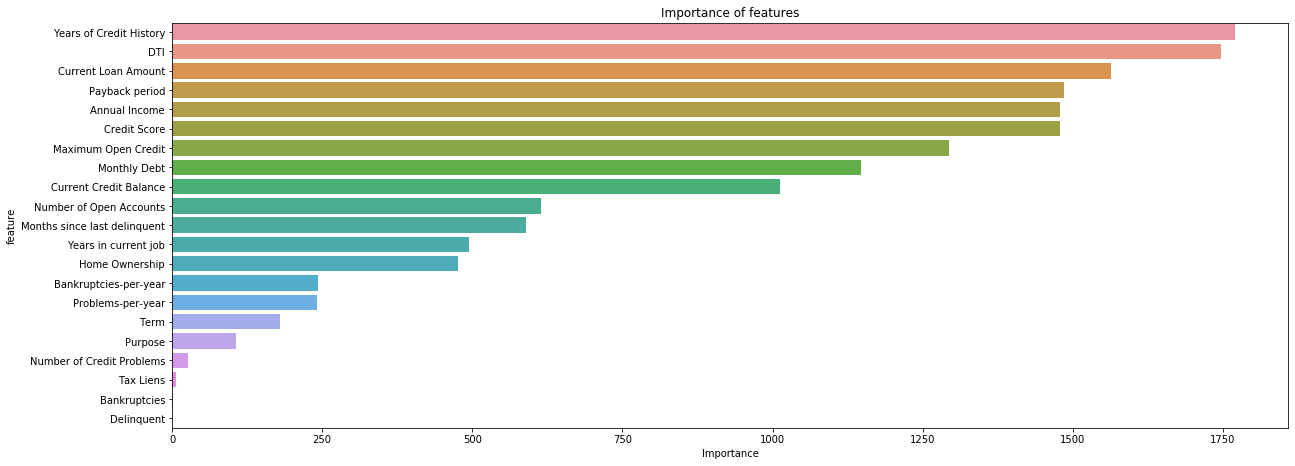

In [162]:
final_model.fit(X, y)

important_features_top = show_feature_importances(X.columns, final_model.feature_importances_, get_top=25)

In [165]:
df_test['Credit Default'] = final_model.predict(df_test.loc[:,FEATURES])
df_test

C:\Users\walde\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Delinquent,DTI,Payback period,Bankruptcies-per-year,Problems-per-year
0,Rent,7.595447e+05,4.5,0.0,9.0,12.5,220968.0,0.0,30.0,0.0,...,162470.000000,105906.0,6813.0,726.340020,0.0,True,0.107638,0.353338,0.000000,0.000000
1,Rent,2.318380e+05,1.5,0.0,6.0,32.7,55946.0,0.0,30.0,0.0,...,78298.000000,46037.0,2318.0,699.000000,0.0,True,0.119980,0.536301,0.000000,0.000000
2,Home Mortgage,1.152540e+06,3.5,0.0,10.0,13.7,204600.0,0.0,164.4,0.0,...,200178.000000,146490.0,18729.0,726.000000,0.0,False,0.195002,0.300786,0.000000,0.000000
3,Home Mortgage,1.220313e+06,12.5,0.0,16.0,17.0,456302.0,0.0,30.0,0.0,...,217382.000000,213199.0,27559.0,739.000000,0.0,True,0.271003,0.352845,0.000000,0.000000
4,Home Mortgage,2.340952e+06,6.5,0.0,11.0,23.6,1207272.0,0.0,283.2,0.0,...,777634.000000,425391.0,42605.0,706.000000,0.0,False,0.218398,0.513904,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1.020053e+06,12.5,0.0,14.0,29.1,559152.0,1.0,41.5,1.0,...,245858.818875,162735.0,15046.0,745.000000,0.0,True,0.177003,0.400561,0.034364,0.034364
2496,Home Mortgage,1.896501e+06,2.5,0.0,15.0,17.0,1737780.0,0.0,30.0,0.0,...,468512.000000,1439269.0,32996.0,731.824224,0.0,True,0.208780,1.005948,0.000000,0.000000
2497,Home Mortgage,1.171806e+06,2.5,0.0,48.0,12.8,1706430.0,0.0,153.6,0.0,...,430496.000000,676438.0,36912.0,695.000000,0.0,False,0.378001,0.944639,0.000000,0.000000
2498,Rent,7.235200e+05,12.5,0.0,14.0,28.8,945780.0,0.0,345.6,0.0,...,257774.000000,391248.0,13506.0,744.000000,0.0,False,0.224005,0.897034,0.000000,0.000000


## Сохранение результатов

In [175]:
df_test.loc[:,['Credit Default']].to_csv('VEvseev_predictions.csv',index=False)

In [176]:
pd.read_csv('VEvseev_predictions.csv')

,Credit Default
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2495,0.0
2496,0.0
2497,0.0
2498,0.0
